# Klasifikasi Gambar Ikan (PyTorch, CUDA 13)
Pipeline end-to-end: load dataset lokal train/val/test, eksplorasi imbalance, augmentasi, class weight, training CNN dari nol, transfer learning EfficientNet-B0, evaluasi (akurasi, confusion matrix, classification report), simpan model terbaik, dan interpretasi Grad-CAM. Semua sel menggunakan PyTorch yang kompatibel dengan CUDA 13 (torch/torchvision cu130).

## 1. Import Library & Set Seed (PyTorch)
Menetapkan seed untuk reproduksibilitas dan menampilkan info perangkat keras (GPU NVIDIA via PyTorch).

In [7]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('PyTorch:', torch.__version__)
print('GPU tersedia:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

PyTorch: 2.9.1+cu130
GPU tersedia: True
GPU: NVIDIA GeForce GTX 1650


## 2. Dataset Lokal
Dataset Fish Image Dataset tersedia lokal dengan struktur `train/val/test`. Tidak perlu unduh ulang.

In [8]:
from pathlib import Path

base_dir = Path.cwd()

def has_dataset_root(p: Path) -> bool:
    return (p / 'train').exists() and (p / 'val').exists() and (p / 'test').exists()

if not has_dataset_root(base_dir):
    raise FileNotFoundError('Folder train/val/test tidak ditemukan. Pastikan dataset lokal tersedia di direktori ini (TASK 3).')

data_dir = base_dir
print('Dataset root:', data_dir)
for split in ['train', 'val', 'test']:
    split_path = data_dir / split
    print(split, '->', len(list(split_path.glob('*/*'))), 'gambar')

Dataset root: c:\Users\HP Pavilion 15\Documents\ML\UAS\TASK 3
train -> 8821 gambar
val -> 2751 gambar
test -> 1761 gambar


## 3. Eksplorasi Imbalance & Class Weight
Hitung distribusi kelas train/val/test dan siapkan class weight untuk mengatasi ketidakseimbangan.

,train,val,test
Bangus,171,52,34
Big Head Carp,201,63,43
Black Spotted Barb,200,63,40
Catfish,314,97,62
Climbing Perch,152,48,30
Fourfinger Threadfin,192,60,38
Freshwater Eel,273,84,55
Glass Perchlet,399,124,77
Goby,607,189,124
Gold Fish,206,65,41


<Figure size 800x400 with 0 Axes>

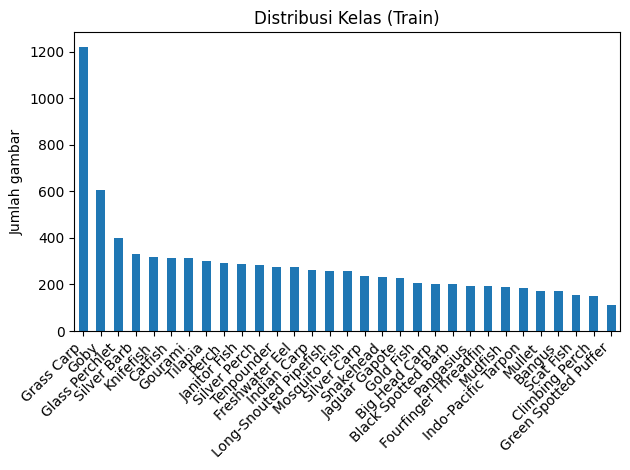

Class weights: {0: 1.6640256555366912, 1: 1.4156636173968866, 2: 1.422741935483871, 3: 0.9062050544483254, 4: 1.8720288624787775, 5: 1.4820228494623655, 6: 1.0423017842372682, 7: 0.7131538523728677, 8: 0.4687782324493809, 9: 1.3813028499843407, 10: 0.9120140612076096, 11: 0.23285465392534713, 12: 2.5868035190615837, 13: 1.086062546170894, 14: 1.5298300381546999, 15: 1.2425693759684462, 16: 0.9949244304083014, 17: 0.8920012134695116, 18: 1.1115171370967742, 19: 1.1115171370967742, 20: 1.4897821313967234, 21: 1.6353355580274378, 22: 1.474343974594685, 23: 0.9711549047671474, 24: 1.8477167993297026, 25: 0.8648887145798607, 26: 1.1955814583898074, 27: 0.9984153933220147, 28: 1.2265016685205785, 29: 1.027250494934203, 30: 0.9422132023071993}


In [9]:
from collections import Counter
import pandas as pd

def count_per_class(split_path: Path):
    counter = Counter()
    for cls_dir in split_path.iterdir():
        if cls_dir.is_dir():
            counter[cls_dir.name] += len(list(cls_dir.glob('*')) )
    return counter

train_counts = count_per_class(data_dir / 'train')
val_counts = count_per_class(data_dir / 'val')
test_counts = count_per_class(data_dir / 'test')

df_counts = pd.DataFrame({'train': train_counts, 'val': val_counts, 'test': test_counts}).fillna(0).astype(int)
display(df_counts)

plt.figure(figsize=(8,4))
df_counts[['train']].sort_values('train', ascending=False).plot(kind='bar', legend=False)
plt.title('Distribusi Kelas (Train)')
plt.ylabel('Jumlah gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Hitung class weight agar kelas minoritas diberi bobot lebih besar
total_train = sum(train_counts.values())
class_weights = {}
for idx, cls in enumerate(sorted(train_counts.keys())):
    class_weights[idx] = total_train / (len(train_counts) * train_counts[cls])
print('Class weights:', class_weights)

## 4. Konfigurasi PyTorch & Device
Siapkan modul PyTorch, deteksi GPU/CPU, dan konfigurasi perangkat.

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_B0_Weights

# Pastikan GPU terdeteksi
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
if device.type == 'cuda':
    print('CUDA capability:', torch.cuda.get_device_name(0))

PyTorch version: 2.9.1+cu130
Device: cuda
CUDA capability: NVIDIA GeForce GTX 1650


## 5. Transformasi, Augmentasi, & DataLoader (PyTorch)
Resize + augmentasi ringan, normalisasi ImageNet, lalu DataLoader untuk train/val/test serta class weight untuk loss.

In [11]:
# Transformasi dan DataLoader PyTorch
IMG_SIZE_PT = 224
BATCH_SIZE_PT = 32
NUM_WORKERS = 4

class_names = sorted(train_counts.keys())
num_classes = len(class_names)
print('Kelas (PyTorch):', class_names)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE_PT, IMG_SIZE_PT)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE_PT, IMG_SIZE_PT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds_pt = datasets.ImageFolder(data_dir / 'train', transform=train_tfms)
val_ds_pt = datasets.ImageFolder(data_dir / 'val', transform=val_tfms)
test_ds_pt = datasets.ImageFolder(data_dir / 'test', transform=val_tfms)

train_loader = DataLoader(train_ds_pt, batch_size=BATCH_SIZE_PT, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds_pt, batch_size=BATCH_SIZE_PT, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds_pt, batch_size=BATCH_SIZE_PT, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Bobot kelas untuk loss (dari perhitungan sebelumnya)
class_weights_pt = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32, device=device)
print('Class weights (PyTorch):', class_weights_pt.cpu().numpy())

Kelas (PyTorch): ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']
Class weights (PyTorch): [1.6640257  1.4156636  1.4227419  0.90620506 1.8720288  1.4820229
 1.0423018  0.71315384 0.46877822 1.3813028  0.91201407 0.23285465
 2.5868034  1.0860626  1.52983    1.2425693  0.9949244  0.8920012
 1.1115172  1.1115172  1.4897821  1.6353356  1.474344   0.9711549
 1.8477168  0.8648887  1.1955814  0.9984154  1.2265017  1.0272505
 0.9422132 ]


## 6. Model CNN Sederhana (Training)
Blok Conv-BN-ReLU + pooling, dropout, dilatih dengan class weight dan mixed precision.

Detail arsitektur CNN: empat blok conv (32→64→128→256), GlobalAvgPool, Dropout 0.4, Dense ke jumlah kelas.

In [12]:
# Definisi model CNN sederhana
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn_model = SimpleCNN(num_classes).to(device)
cnn_criterion = nn.CrossEntropyLoss(weight=class_weights_pt)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda'))

EPOCHS_CNN = 12
best_cnn_acc = 0.0
best_cnn_state = None

for epoch in range(1, EPOCHS_CNN + 1):
    cnn_model.train()
    run_loss = 0.0
    run_correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        cnn_optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            outputs = cnn_model(imgs)
            loss = cnn_criterion(outputs, labels)
        cnn_scaler.scale(loss).backward()
        cnn_scaler.step(cnn_optimizer)
        cnn_scaler.update()

        preds = outputs.argmax(dim=1)
        run_correct += (preds == labels).sum().item()
        run_loss += loss.item() * labels.size(0)
        total += labels.size(0)

    train_loss = run_loss / total
    train_acc = run_correct / total

    # Validasi
    cnn_model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
                outputs = cnn_model(imgs)
                loss = cnn_criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_loss_sum += loss.item() * labels.size(0)
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_sum / val_total
    if val_acc > best_cnn_acc:
        best_cnn_acc = val_acc
        best_cnn_state = cnn_model.state_dict()

    print(f"[CNN] Epoch {epoch}/{EPOCHS_CNN} | Train Acc: {train_acc:.3f} Loss: {train_loss:.4f} | Val Acc: {val_acc:.3f} Loss: {val_loss:.4f}")

if best_cnn_state:
    cnn_model.load_state_dict(best_cnn_state)
    torch.save(cnn_model.state_dict(), 'cnn_pytorch_best.pt')
    print('Disimpan: cnn_pytorch_best.pt (state dict)')

[CNN] Epoch 1/12 | Train Acc: 0.149 Loss: 3.0593 | Val Acc: 0.178 Loss: 2.8859
[CNN] Epoch 2/12 | Train Acc: 0.201 Loss: 2.8670 | Val Acc: 0.221 Loss: 2.7047
[CNN] Epoch 3/12 | Train Acc: 0.236 Loss: 2.7439 | Val Acc: 0.226 Loss: 2.7370
[CNN] Epoch 4/12 | Train Acc: 0.272 Loss: 2.6417 | Val Acc: 0.304 Loss: 2.4329
[CNN] Epoch 5/12 | Train Acc: 0.311 Loss: 2.5225 | Val Acc: 0.334 Loss: 2.3599
[CNN] Epoch 6/12 | Train Acc: 0.320 Loss: 2.4623 | Val Acc: 0.346 Loss: 2.2794
[CNN] Epoch 7/12 | Train Acc: 0.340 Loss: 2.3810 | Val Acc: 0.296 Loss: 2.5190
[CNN] Epoch 8/12 | Train Acc: 0.360 Loss: 2.3214 | Val Acc: 0.353 Loss: 2.3993
[CNN] Epoch 9/12 | Train Acc: 0.370 Loss: 2.2654 | Val Acc: 0.370 Loss: 2.3828
[CNN] Epoch 10/12 | Train Acc: 0.392 Loss: 2.1920 | Val Acc: 0.437 Loss: 1.9979
[CNN] Epoch 11/12 | Train Acc: 0.392 Loss: 2.1827 | Val Acc: 0.393 Loss: 2.0699
[CNN] Epoch 12/12 | Train Acc: 0.413 Loss: 2.1107 | Val Acc: 0.466 Loss: 1.8706
Disimpan: cnn_pytorch_best.pt (state dict)


## 7. Evaluasi CNN (Test Set)
Menggunakan bobot terbaik CNN untuk akurasi, confusion matrix, dan classification report.

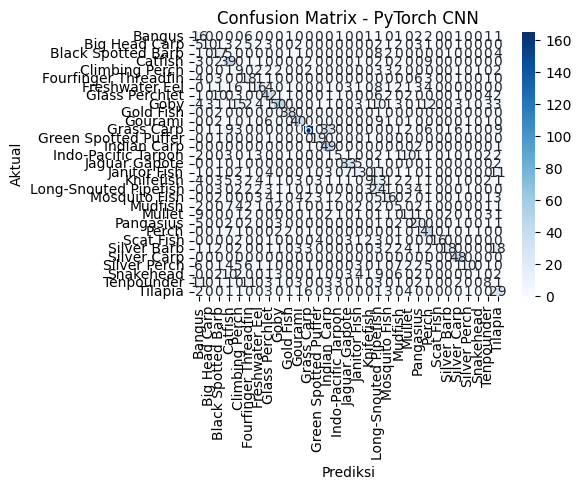

                       precision    recall  f1-score   support

               Bangus       0.21      0.47      0.29        34
        Big Head Carp       0.62      0.23      0.34        43
   Black Spotted Barb       0.29      0.42      0.35        40
              Catfish       0.39      0.63      0.48        62
       Climbing Perch       0.14      0.30      0.19        30
 Fourfinger Threadfin       0.29      0.47      0.36        38
       Freshwater Eel       0.40      0.29      0.34        55
       Glass Perchlet       0.51      0.55      0.53        77
                 Goby       0.74      0.40      0.52       124
            Gold Fish       0.81      0.93      0.86        41
              Gourami       0.69      0.63      0.66        63
           Grass Carp       0.89      0.69      0.78       238
 Green Spotted Puffer       0.61      0.86      0.72        22
          Indian Carp       0.49      0.92      0.64        53
  Indo-Pacific Tarpon       0.36      0.13      0.19  

In [13]:
# Evaluasi CNN
cnn_model.eval()
if best_cnn_state:
    cnn_model.load_state_dict(best_cnn_state)

y_true = []
y_pred = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            outputs = cnn_model(imgs)
        preds = outputs.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm_cnn = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - PyTorch CNN')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

## 8. Transfer Learning: EfficientNet-B0 (Training)
Fine-tuning ringan bobot ImageNet, head diganti sesuai jumlah kelas; class weight & mixed precision digunakan.

In [14]:
# Model EfficientNet-B0 + fine-tuning ringan (head diganti)
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_pt)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda'))

best_acc = 0.0
best_state = None
EPOCHS_PT = 10

for epoch in range(1, EPOCHS_PT + 1):
    model.train()
    run_loss = 0.0
    run_correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = outputs.argmax(dim=1)
        run_correct += (preds == labels).sum().item()
        run_loss += loss.item() * labels.size(0)
        total += labels.size(0)

    train_loss = run_loss / total
    train_acc = run_correct / total

    # Validasi
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_loss_sum += loss.item() * labels.size(0)
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_sum / val_total
    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict()

    print(f"Epoch {epoch}/{EPOCHS_PT} | Train Acc: {train_acc:.3f} Loss: {train_loss:.4f} | Val Acc: {val_acc:.3f} Loss: {val_loss:.4f}")

if best_state:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), 'eff_b0_pytorch_best.pt')
    print('Disimpan: eff_b0_pytorch_best.pt (state dict)')

Epoch 1/10 | Train Acc: 0.613 Loss: 1.8812 | Val Acc: 0.887 Loss: 0.5688
Epoch 2/10 | Train Acc: 0.889 Loss: 0.4767 | Val Acc: 0.956 Loss: 0.2054
Epoch 3/10 | Train Acc: 0.936 Loss: 0.2467 | Val Acc: 0.975 Loss: 0.1126
Epoch 4/10 | Train Acc: 0.958 Loss: 0.1578 | Val Acc: 0.986 Loss: 0.0687
Epoch 5/10 | Train Acc: 0.971 Loss: 0.1057 | Val Acc: 0.986 Loss: 0.0578
Epoch 6/10 | Train Acc: 0.979 Loss: 0.0791 | Val Acc: 0.990 Loss: 0.0409
Epoch 7/10 | Train Acc: 0.983 Loss: 0.0649 | Val Acc: 0.989 Loss: 0.0405
Epoch 8/10 | Train Acc: 0.985 Loss: 0.0543 | Val Acc: 0.993 Loss: 0.0364
Epoch 9/10 | Train Acc: 0.984 Loss: 0.0551 | Val Acc: 0.992 Loss: 0.0339
Epoch 10/10 | Train Acc: 0.989 Loss: 0.0423 | Val Acc: 0.993 Loss: 0.0336
Disimpan: eff_b0_pytorch_best.pt (state dict)


## 9. Evaluasi EfficientNet-B0
Gunakan bobot terbaik untuk test set: akurasi, confusion matrix, dan classification report.

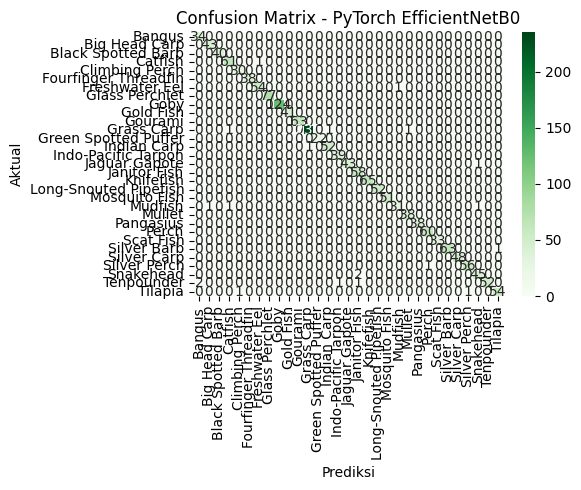

                       precision    recall  f1-score   support

               Bangus       0.94      1.00      0.97        34
        Big Head Carp       0.98      1.00      0.99        43
   Black Spotted Barb       1.00      1.00      1.00        40
              Catfish       0.97      0.98      0.98        62
       Climbing Perch       0.97      1.00      0.98        30
 Fourfinger Threadfin       1.00      1.00      1.00        38
       Freshwater Eel       0.98      0.98      0.98        55
       Glass Perchlet       1.00      1.00      1.00        77
                 Goby       1.00      1.00      1.00       124
            Gold Fish       1.00      1.00      1.00        41
              Gourami       1.00      1.00      1.00        63
           Grass Carp       1.00      0.99      0.99       238
 Green Spotted Puffer       1.00      1.00      1.00        22
          Indian Carp       0.98      0.98      0.98        53
  Indo-Pacific Tarpon       0.97      1.00      0.99  

In [15]:
# Evaluasi pada test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm_pt = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - PyTorch EfficientNetB0')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

## 10. Grad-CAM (EfficientNet-B0)
Visualisasi area perhatian model pada beberapa contoh test.

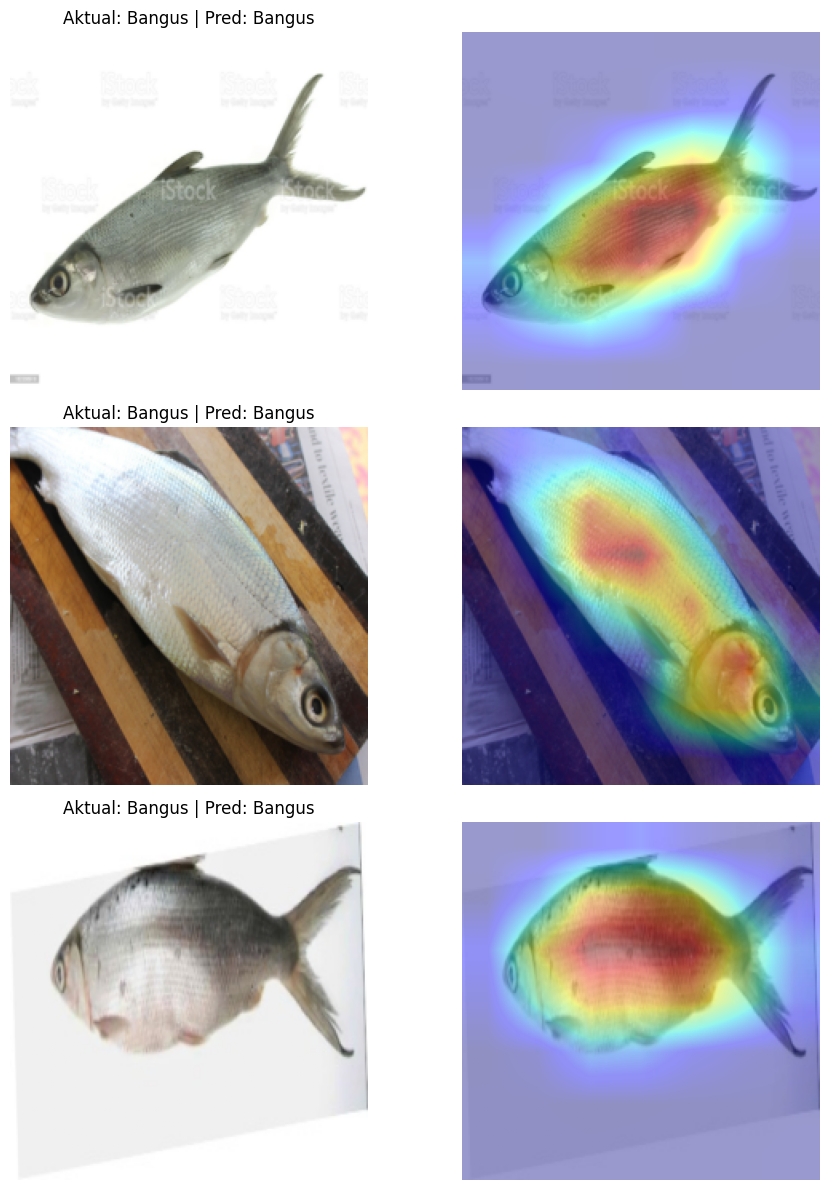

In [16]:
# Grad-CAM util untuk EfficientNet-B0
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.fwd_hook = target_layer.register_forward_hook(self._save_activation)
        self.bwd_hook = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        selected = output[0, class_idx]
        selected.backward()
        grads = self.gradients[0]          # [C,H,W]
        activations = self.activations[0]  # [C,H,W]
        weights = grads.mean(dim=(1,2))
        cam = (weights[:, None, None] * activations).sum(dim=0)
        cam = torch.relu(cam)
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        cam = cam.cpu().numpy()
        return cam

def denorm(img_tensor):
    # img_tensor: [C,H,W] normalized with ImageNet stats
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor.cpu() * std + mean
    return img.clamp(0,1)

# Siapkan model (gunakan bobot terbaik EfficientNet jika ada)
if best_state:
    model.load_state_dict(best_state)
model.eval()

# Hook di feature map terakhir EfficientNet-B0
cam_extractor = GradCAM(model, model.features[-1])

# Ambil beberapa sampel test
n_samples = 3
fig, axes = plt.subplots(n_samples, 2, figsize=(10, 4*n_samples))
for i in range(n_samples):
    img, label = test_ds_pt[i]
    input_tensor = img.unsqueeze(0).to(device)
    with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
        _ = model(input_tensor)
    cam = cam_extractor.generate(input_tensor)
    pred_idx = _.argmax(dim=1).item()

    img_disp = denorm(img)
    cam_resized = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
    cam_resized = torch.nn.functional.interpolate(cam_resized, size=img.shape[1:], mode='bilinear', align_corners=False)[0,0].numpy()

    ax1, ax2 = axes[i]
    ax1.imshow(np.moveaxis(img_disp.numpy(), 0, 2))
    ax1.set_title(f'Aktual: {class_names[label]} | Pred: {class_names[pred_idx]}')
    ax1.axis('off')

    ax2.imshow(np.moveaxis(img_disp.numpy(), 0, 2))
    ax2.imshow(cam_resized, cmap='jet', alpha=0.4)
    ax2.axis('off')
plt.tight_layout()
plt.show()


## 11. Ringkasan
- Pipeline end-to-end PyTorch + CUDA 13: augmentasi, class weight, CNN dari nol, EfficientNet-B0, evaluasi, Grad-CAM.
- Model terbaik tersimpan: `cnn_pytorch_best.pt` dan `eff_b0_pytorch_best.pt` (state dict). Untuk inferensi, buat ulang arsitektur lalu `model.load_state_dict(torch.load(...))`.
- Dataset lokal sudah tersusun train/val/test; seluruh training loop menggunakan mixed precision bila GPU tersedia.